# Implementing cometary aperture correction in Sorcha

This notebook demonstrates an attempt to take cometary magnitudes measured in a 5" aperture and correct them to an LSST "PSF" magnitude, to enable realistic predictions for detections of distant LPCs using Sorcha. 

I assume a circularly-symmetrical coma which drops in brightness as 1/rho (i.e. with inverse distance from the optocentre). 

The relative contributions from the coma and the nucleus are scalable, meaning we can modify how 'diffuse' the simulated comet is (between 100% coma and 100% point source), and the total brightness of the comet is measured as the convolved sum of the nucleus and coma contributions.

Some iffy sky background is incorporated as noise - in this notebook this is set to a fixed per-pixel count level using a constant sky brightness.

In [50]:
# Import functions and set up a few constants: 

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.modeling import models, fitting
from astropy.convolution import Gaussian2DKernel, convolve
from photutils.psf import GaussianPSF, PSFPhotometry
from photutils.aperture import CircularAperture, aperture_photometry

from scipy.integrate import nquad,IntegrationWarning
import warnings

from phase import phase_HalleyMarcus

arcsec_to_rad = (1./3600.)*(np.pi/180.)
AU_km = 1.496e8

## Use average Hab comet brightness to get apparent mag for an example LPC

In [51]:
# These are the parameters that define an 'average' Hab comet's brightness as a function of its observing geometry.
# use these to get apparent magnitudes.

a_med =  0.291003 
b_med = -0.979686
m1_med = 9.451208

In [ ]:
# Define range of heliocentric distances at which to generate comet brightness
rh = np.linspace(1,20,20)

## Get geocentric distances to go with these heliocentric distances

In [55]:
# alpha = []
# i = 0
# while len(alpha)<len(rh):
#     random_angle = (np.random.lognormal(mean=1.5, sigma=1, size=None)*np.pi/180)
#     if np.sin(random_angle)*rh[i]>=1:
#         continue
#     else:
#         alpha.append(random_angle)
#         i+=1
# alpha = np.array(alpha)
# #plt.hist(alpha*180/np.pi)
# plt.hist(alpha*180/np.pi)
# plt.show()
# print(alpha)
alpha = [0.11823977, 0.09523437, 0.03283952, 0.11947476, 0.03096393, 0.1236366, 0.03102322, 0.12095512, 0.02602624,0.03933764,0.02053758,0.04601842, 0.02586491,0.06151247,0.05594175,0.03527774,0.00772937,0.01315781,0.03724828,0.03437115]

In [56]:
# Define space of heliocentric (rh) and geocentric (delta) distances:

#alpha*=(np.pi/180)
# Get sin of elongation angle from sine rule
sin_eps = rh*np.sin(alpha)
eps = np.arcsin(sin_eps)*(180/np.pi)

# Get delta from cosine law

def cos_rule(b,A):
    # Assuming side c is equal to 1 au (i.e. Earth-Sun distance)
    # Elongation A in degrees
    A_rad = (np.pi/180.)*A
    a_square = np.square(b) + 1 - (2.*b*np.sin(A_rad))
    side_a = np.sqrt(a_square)
    return side_a

delta = cos_rule(rh, eps)
print('List of geocentric distances:' )
print(delta)

List of geocentric distances:
[ 1.32818338  2.05895026  3.0674085   3.631239    4.9449015   5.30290735
  6.85275215  7.0395645   8.81953656  9.65062179 10.81805227 11.47830006
 12.6987651  13.1492325  14.17177973 15.45773409 16.89770602 17.78971571
 18.30609079 19.32636784]


## Use Hab model to generate apparent magnitudes at each geometry

In [57]:
def Hab2mr(a,b,M1, delta, rh, alpha):
    # a, b, M1: parameters of Hab model
    # delta, rh, alpha: comet geometry
    
    phi = phase_HalleyMarcus(alpha)
    # Determine heliocentric brightness and convert this to an apparent magnitude
    mHelio = M1 + 2.5*((a*rh)+b)*np.log10(rh)
    mr = mHelio + 2.5*np.log10(delta) - 2.5*np.log10(phi)
    
    return mr

# List of apparent comet magnitudes at every rh
m_app = Hab2mr(a_med, b_med, m1_med, delta, rh, alpha)

## Setup functions and constants

In [116]:
# analytic coma law
def coma_intensity(x, y):
    # scale factor (k in k/r) determined using the magnitude contribution within the 5" aperture
    # therefore just input 1/rho law into integral
    r = np.sqrt(np.square(x)+np.square(y))
    if r == 0:
        return 0.0
    return 1 / r

# def pixel_integral_1_over_r(x0, x1, y0, y1):
#     """Analytic integral of 1/r over a rectangular pixel."""
#     def F(x, y):
#         r = np.sqrt(x**2 + y**2)
#         return y * np.log(x + r + 1e-300) + x * np.log(y + r + 1e-300)
#     return F(x1, y1) - F(x1, y0) - F(x0, y1) + F(x0, y0)

def integrate_over_pixels(xc,yc,pix_size_km):
    # Function to integrate coma function over LSST pixels
    # Inputs: xc, yx: coordinates of a square pixel centre [km]
    # pix_size_km: Distance at the comet subtended by a pixel [km]
    
    # get pixel edges using the input distance at pixel centre
    x0, x1 = xc - pix_size_km/2, xc + pix_size_km/2
    y0, y1 = yc - pix_size_km/2, yc + pix_size_km/2
    
    # Perform integration (kind of slow)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", IntegrationWarning)
        val, _ = nquad(lambda yy, xx: coma_intensity(xc, yc),[[x0, x1], [y0, y1]], opts={'limit': 50, 'epsabs': 1e-8, 'epsrel': 1e-8})
    return val

[8.22690128e+08 6.99807490e+08 4.01946407e+08 2.33046096e+08
 1.03199496e+08 5.21867700e+07 2.04483419e+07 9.40218619e+06
 3.39149284e+06 1.33359732e+06 4.92971218e+05 1.85628326e+05
 6.51074279e+04 2.36642803e+04 8.06691251e+03 2.65503887e+03
 8.53158951e+02 2.78495286e+02 9.11678584e+01 2.86017171e+01]
676.2483966894376


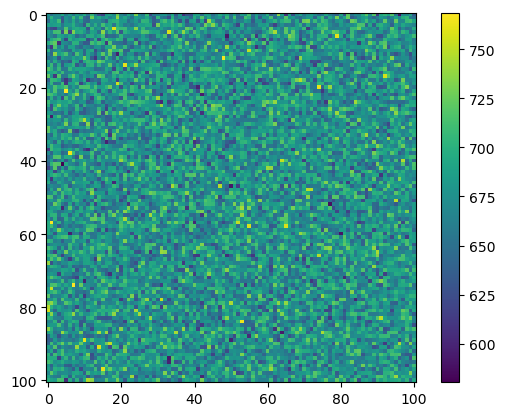

In [124]:
size = 101 # number of synthetic pixels for evaluating coma over
centre = size//2 # integer central pixel
central_region = np.arange(centre-2,centre+3) # defining small central region over which to perform slow integration.
extent = [-size//2,size//2, -size//2,size//2] # for imshow

pxsc = 0.2 # LSST pixel scale in arcsec/pixel

# Set up a few grid definitionss
arcsec_arr = np.zeros([size,size])
coords_pix = np.arange(-(size//2), (size//2)+1) # n pixels
coords_ac = coords_pix * pxsc # arcsecond coordinates at centre of pixel

for i,x in enumerate(coords_ac):
    for j,y in enumerate(coords_ac):
        theta = np.sqrt(np.square(x)+np.square(y))
        arcsec_arr[j,i] = theta # angular distance from central pixel at centre of each pixel in the grid

# constants for getting flux + noise (from https://smtn-002.lsst.io/ assuming gain = 1)        
t_exp = 30.
ZP_r = 28.36
dark = 0.2 
readnoise = 8.8 #photo-electrons/second/pixel

# Convert comet magnitudes to fluxes/counts
fluxj = t_exp * 10**(-0.4*(m_app-ZP_r))
print(fluxj)

#\[m_{inst} = -2.5\log(N/t) + C\]
# 2.5log(flux) = C - m_inst
# flux = 10**0.4(C-m_inst)

# Adding a couple of noise-related 'constants' (these would be field-dependent in Sorcha)
# Mainly sky noise
# This converts the sky background from mag/sq. arcsecond to a flux level per pixel 
#m_sky = 22 # mag/square arcsec
#counts_sky = t_exp * 10**(-0.4*(m_sky-ZP_r)) # flux per square arcsecond

m_5sig = 24.5
counts_5sig = t_exp * 10**(-0.4*(m_5sig-ZP_r))

sig_inst_sq = np.square(readnoise) + (t_exp*dark)

seeing_val = 1.
n_eff = 2.266*np.square(seeing_val/pxsc)

sky_per_pixel = (counts_5sig/n_eff)*((counts_5sig/25)-1) - sig_inst_sq
print(sky_per_pixel)

# sky_per_pixel = np.square(pxsc) * counts_sky
# print(f'Sky flux per pixel: {sky_per_pixel:.2e}')

# # poisson noise:
sigma_sky = np.sqrt(sky_per_pixel)

# Generate sky background array using mean = sky_per_pixel and uncertainty sky_sigma (sqrt sky_per_pixel)
sky_bkg = np.random.normal(sky_per_pixel, sigma_sky, size=(size,size))
plt.imshow(sky_bkg)
plt.colorbar()

## Main loop
The next cell loops through user-defined seeing values (in arcseconds) and object geometries and creates a synthetic comet at each. Run photutils PSFphotometry on the synthetic comet (Gaussian fit) and return the final counts in comparison with the original big aperture counts.

**Problem: The final PSF mag that would be fed into Sorcha as the PSFmag appears to get brighter as a function of seeing. Is this a result of the infinitely-extending coma model?**

******------Seeing [arcsec]: 1.0------******

FWHM of seeing disc = 5.0000 pixels
One pixel at delta = 12.7 au is 1842.04 km
Fitting model with FWHM= 1.0 arcsec


Results from PSFphotometry:
flux_init   flux_fit  qfit
---------- ---------- ----
6.5107e+04 9.2189e+03  4.1


Aperture photometry for comparison:
 id xcenter ycenter aperture_sum
--- ------- ------- ------------
  1    50.0    50.0     1.12e+04


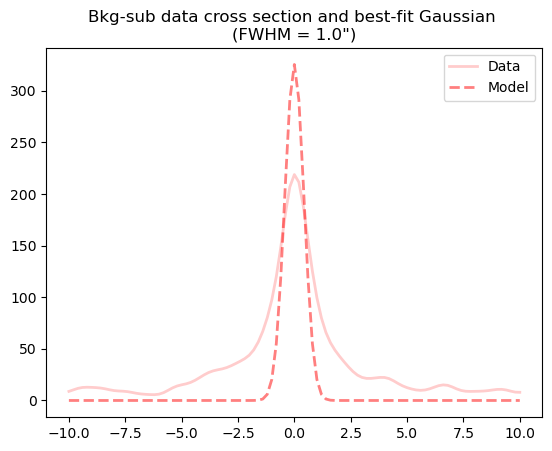

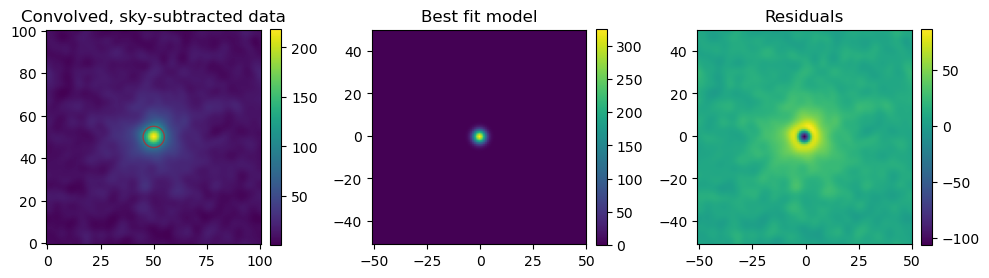

Initial flux: 6.5107e+04  PSF flux: 9.2189e+03
Initial 5" mag: >>>>>>>>>>20.02<<<<<<<<<<
Final PSF mag: >>>>>>>>>>22.14<<<<<<<<<<
----*-*-*-*-*-*-*-*-*-*-*-*-----

******------Seeing [arcsec]: 2.0------******

FWHM of seeing disc = 10.0000 pixels
One pixel at delta = 12.7 au is 1842.04 km
Fitting model with FWHM= 2.0 arcsec


Results from PSFphotometry:
flux_init   flux_fit  qfit
---------- ---------- ----
6.5107e+04 1.9426e+04  1.5


Aperture photometry for comparison:
 id xcenter ycenter aperture_sum
--- ------- ------- ------------
  1    50.0    50.0     2.32e+04


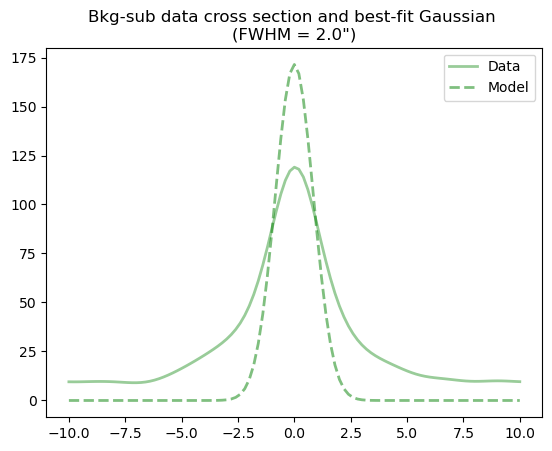

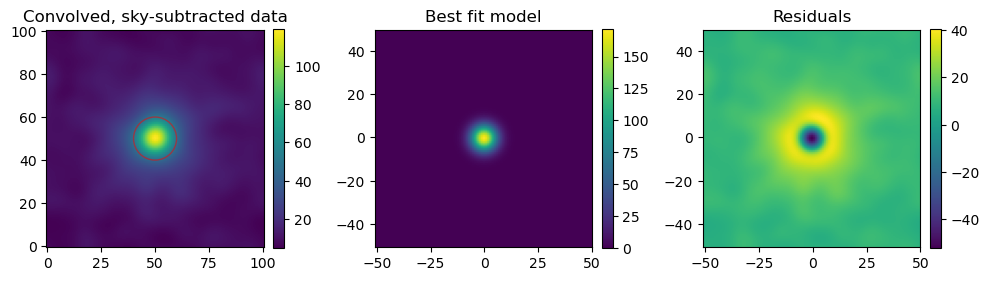

Initial flux: 6.5107e+04  PSF flux: 1.9426e+04
Initial 5" mag: >>>>>>>>>>20.02<<<<<<<<<<
Final PSF mag: >>>>>>>>>>21.33<<<<<<<<<<
----*-*-*-*-*-*-*-*-*-*-*-*-----

******------Seeing [arcsec]: 3.0------******

FWHM of seeing disc = 15.0000 pixels
One pixel at delta = 12.7 au is 1842.04 km
Fitting model with FWHM= 3.0 arcsec


Results from PSFphotometry:
flux_init   flux_fit  qfit
---------- ---------- ----
6.5107e+04 2.9138e+04  0.6


Aperture photometry for comparison:
 id xcenter ycenter aperture_sum
--- ------- ------- ------------
  1    50.0    50.0     3.50e+04


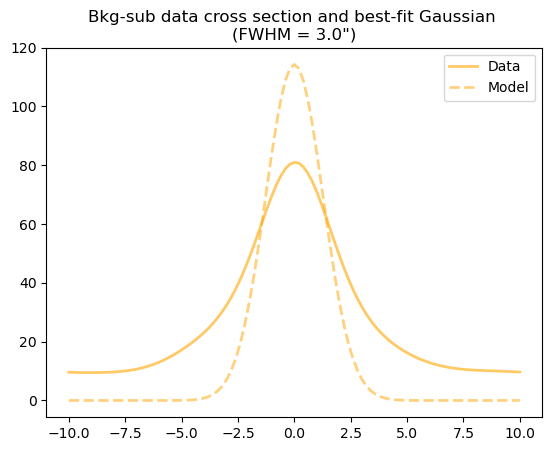

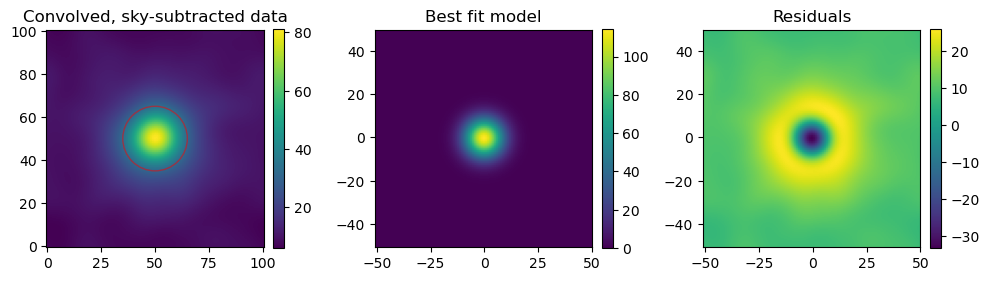

Initial flux: 6.5107e+04  PSF flux: 2.9138e+04
Initial 5" mag: >>>>>>>>>>20.02<<<<<<<<<<
Final PSF mag: >>>>>>>>>>20.89<<<<<<<<<<
----*-*-*-*-*-*-*-*-*-*-*-*-----



In [133]:
# Set ratio of nucleus to coma contribution (i.e. how pointsource-like)
nuc_fraction = 0.01
coma_fraction = 1. - nuc_fraction

# Quick way to limit the loop to only a few geometries.
ind_list = [12]
r_list = rh[ind_list]
d_list = delta[ind_list]
f_list = fluxj[ind_list]
m_list = m_app[ind_list]

# Define the seeing values (in arcsec)
seeing_ac = [1.,2.,3.]

# --- set up plotting --- #

for v, seeing_val in enumerate(seeing_ac):
    
    nuc_frac = nuc_fraction
    coma_frac = coma_fraction
    
    print(f'******------Seeing [arcsec]: {seeing_val}------******\n')

    for k,(r,d,f,m) in enumerate(zip(r_list, d_list,f_list,m_list)):
    
        # Setting up seeing-PSF with which to convolve coma
        fwhm = seeing_val/pxsc    # FWHM of seeing disc in pixels
        sigma = fwhm/2.355
        print(f'FWHM of seeing disc = {fwhm:.4f} pixels')
        
        # Get the total comet flux within the 5-arcsecond aperture
        flux = f #fluxj[k]
        
        # Define the relative contributions from the point source and the coma 
        f_coma = coma_frac * flux
        f_nuc = nuc_frac * flux
        
        # pixel coordinates in km - distance dependent
        pix_size_km = (pxsc*arcsec_to_rad) * d*AU_km
        print(f'One pixel at delta = {d:.1f} au is {pix_size_km:.2f} km')
        coords_km = coords_pix * pix_size_km

        # Build the coma
        coma = np.zeros([size,size])
        
        # integrate coma into each pixel for central 5x5, evaluate 1/r further from centre for speed
        for i, xc in enumerate(coords_km):
            for j, yc in enumerate(coords_km):
                if i in central_region and j in central_region:
                    val = integrate_over_pixels(xc,yc,pix_size_km)
                else:
                    # for speed: evaluate 1/r at pixel centre and times by pixel area
                    val = coma_intensity(xc,yc)*np.square(pix_size_km)
                coma[j, i] = val 

        # re-scaling the coma to the correct flux level
        # find pixels with centres within 5"
        aper_mask = arcsec_arr <= 5.
        flux_raw = np.nansum(coma[aper_mask])
        
        # scale coma to flux level within 5"
        coma_scalefac = f_coma/flux_raw
        coma_scaled = coma*(coma_scalefac)
        #print(f'scaled coma flux within 5" aperture: {np.sum(coma_scaled[aper_mask]):.4e}')
        
  
        # nucleus is a dirac delta function with fnuc signal in central pixel and zero elsewhere
        dirac_delta = np.zeros_like(coma_scaled)
        dirac_delta[size//2,size//2] = f_nuc

        # Sum the nucleus, coma and sky background before convolving with Gaussian kernel
        lamy_sum = dirac_delta + coma_scaled
        lamy_sum+=sky_bkg
        
        #print(f'Pre-convolution sum: {np.sum(lamy_sum):.1e}')
        
        kernel2d = Gaussian2DKernel(x_stddev=sigma, y_stddev=sigma, theta=0, x_size=size, y_size=size)
        kernel2d.normalize()
        
        conv = convolve(lamy_sum, kernel2d, boundary='wrap')
        #conv+=sky_bkg
        
        
        # Photometry section 
        postage = 31 # for model fitting
        
        # flux-fitting steps
        # Perform photometry using fixed FWHM Gaussian (~seeing disc)
        print(f'Fitting model with FWHM= {fwhm*pxsc} arcsec')
        psf_model = GaussianPSF(flux=1, x_0 = size//2 , y_0 = size//2, x_fwhm=fwhm, y_fwhm=fwhm, theta=0.)
        psf_model.flux.fixed=False
        psf_model.x_0.fixed=True # to avoid getting lost in the noise
        psf_model.y_0.fixed=True
        psf_model.x_fwhm.fixed=True
        psf_model.y_fwhm.fixed=True
        psf_model.theta.fixed=False
        
        #print(psf_model.amplitude)
        
        # prepare initial guess table
        init_tab = astropy.table.Table()
        init_tab['x_0'] = [size//2]
        init_tab['y_0'] = [size//2]
        init_tab['flux_init'] = f
        #init_tab['x_fwhm'] = fwhm
        #init_tab['y_fwhm'] = fwhm
        
        fitter = fitting.LMLSQFitter()
        
        # subtract mean sky level from each pixel
        data_to_fit = conv-sky_per_pixel 
        
        phot = PSFPhotometry(psf_model=psf_model, fit_shape=postage, fitter=fitter, fitter_maxiters=300, localbkg_estimator=None)
        
        result = phot(data_to_fit, init_params=init_tab)        
        result['flux_init'].info.format = '.4e'; result['flux_fit'].info.format = '.4e'; result['qfit'].info.format = '.1f' 
        print('\n')
        print('Results from PSFphotometry:')
        result[['flux_init', 'flux_fit', 'qfit']].pprint_all()
        
        # checking aperture photometry results
        apertures = CircularAperture((result['x_fit'].value[0],result['y_fit'].value[0]),r=fwhm)
        ap_phot = aperture_photometry(data = data_to_fit, apertures=apertures)
        ap_phot['aperture_sum'].info.format = '.2e'
        print('\n')
        print('Aperture photometry for comparison:')
        ap_phot.pprint_all()
        
        model_2d = phot.make_model_image(conv.shape,include_localbkg=False)

        data_1d = conv[size//2,:]
        data_sub_1d = data_to_fit[size//2,:]
        model_1d = model_2d[size//2,:]
        unconv_1d = lamy_sum[size//2,:]
        
# #################################        
        col_cycler = ['red', 'green', 'orange']
        plt.plot(coords_ac, data_sub_1d, lw=2, color = col_cycler[v], alpha=seeing_val*0.2, label='Data')
        plt.plot(coords_ac, model_1d, lw=2, ls = '--', alpha=0.5,color = col_cycler[v], label='Model')#, label=f'FWHM: {fwhm_fit*pxsc:.2f}')
        plt.title(f'Bkg-sub data cross section and best-fit Gaussian \n(FWHM = {seeing_val}")')
        plt.legend()
        plt.show()
# ################################
#         extent=[-max(coords_ac),max(coords_ac), -max(coords_ac), max(coords_ac)]
# #         # Plot of 2D comet plus model and residual
        fig1, ax1 = plt.subplots(1, 3, figsize=(10, 4))

        im0 = ax1[0].imshow(data_to_fit, origin='lower')#,extent=extent)
        apertures.plot(ax = ax1[0], color='red', alpha=0.5)
        ax1[0].set_title('Convolved, sky-subtracted data')
        fig1.colorbar(im0, ax=ax1[0], fraction=0.046, pad=0.04)

        im1 = ax1[1].imshow(model_2d, origin='lower',extent=extent)
        ax1[1].set_title('Best fit model')
        fig1.colorbar(im1, ax=ax1[1], fraction=0.046, pad=0.04)

        im2 = ax1[2].imshow(data_to_fit-model_2d, origin='lower',extent=extent)
        ax1[2].set_title('Residuals')
        fig1.colorbar(im2, ax=ax1[2], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()
        
# ################################        
        # Determine new magnitude for sorcha PSF mag
        #m2 - m1 = 2.5log(f1/f2)
        
        flux_fit = result['flux_fit'].value[0]
        flux_ratio = flux_fit/flux
        #final_flux.append(flux_fit)
        #print(f'flux ratio: {flux_ratio:.3f}')
        m2 = m
        m1 = m2 - 2.5*np.log10(flux_ratio)

        #m1_list.append(m1)
        #print(f'mag difference for delta = {d:.1f} au: >>>>>>>{m1-m2:.2f}<<<<<<<')
        print(f'Initial flux: {f:.4e}  PSF flux: {flux_fit:.4e}')
        
        print(f'Initial 5" mag: >>>>>>>>>>{m2:.2f}<<<<<<<<<<')
        print(f'Final PSF mag: >>>>>>>>>>{m1:.2f}<<<<<<<<<<')
        
        mag_diff = m1-m2
        
# #################################        
        
        plt.show()
        

        print('----*-*-*-*-*-*-*-*-*-*-*-*-----\n')
